### Log Entry for Naive Bayes Chnages

This notebook contains code from [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas. 

The original notebook demonstrated text classification trained on emails. 
In my version, I perform text classification by training the model on BBC news articles.

#### 1. Algorithm Understanding:
- **Objective:**
  - Gain a deep understanding of the Naive Bayes algorithm. How the model and decides where the decision boundry is 
- **Changes:**
  1. Used `make_gaussian_quantiles` instead of `make_blobs`.
  <p float="left">
  <img src="figures/gaussianNaiveOrg.png" width="200" />
  <img src="figures/gaussiamBayesMod.png" width="200" />
  </p>
  2. Fitting the model stays the same, Then I generated some new data. <br>
  3. Plot the new data to see where the decision boundary is:
  <p float="left">
    <img src="figures/Fig3.png" width="200" />
    <img src="figures/Fig4.png" width="200" />
  </p>
  4. Output: For the first six samples, the model is quite confident that they belong to the positive class.
  For the seventh sample, the model is less confident. For the eighth sample, the model is again confident.

### Naive Bayes Text Classifier using BBC news reports 

#### 1. Data Understanding:
- **Dataset Description:**
  - VanderPlas used a collection from sklearn called 20 Newsgroups. 
    - It contains around 18,000 newsgroup documents from 20 different newsgroups.
    
  **Changes:**
  - In my model, I use the `BBC News Archive` dataset.
    - The dataset comprises 2225 documents from the BBC news from 2004-2005.
    - Five catageories: Business, Entertainment, Politics, Sport, Tech
    - The data is processed into a single CSV file
    - The dataset is structured with columns for 'content' (text) and 'category' (news category).


#### 2. Data Preparation:
- **Data Cleaning:**
  - VanderPlas does not preform any data cleaning.
  **Changes:**
  2. For my model, I preformed initial data cleaning steps, checking for duplicated rows and null values.
    The dataset was clean and there were no nulls. 


  - **Feature Engineering:**
  - Feature engineering used in this notebook is the use of the TF-IDF vectorizer, which transforms text data into numerical features based on word frequencies and document importance.

#### 3. Modeling
- **Implementation Details:**
  - Utilized the `TfidfVectorizer` to convert the text data into numerical features using the TF-IDF (Term Frequency-Inverse Document Frequency)
  - Created a pipeline (`make_pipeline`) that combines the TF-IDF vectorizer with the Multinomial Naive Bayes classifier.
  
- ** 4. Performance Metrics:**
  - The evaluation metric used is accuracy, calculated using the `accuracy_score` from `sklearn.metrics`.

#### 6. Reflection and Analysis:
- **Challenges Encountered:**




- **Unexpected Results:**




#### 9. Overall Conclusion:
- **Summary:**



In [1]:
# Standard imports 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Algorithm Understanding


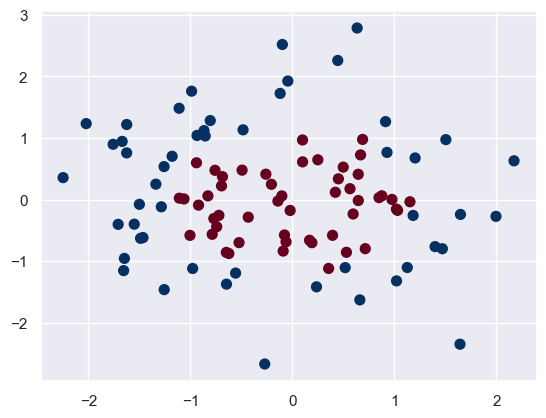

In [2]:
from sklearn.datasets import make_gaussian_quantiles
X, y = make_gaussian_quantiles(n_samples=100, n_features=2, n_classes=2, random_state=145)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')


In [3]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

In [4]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

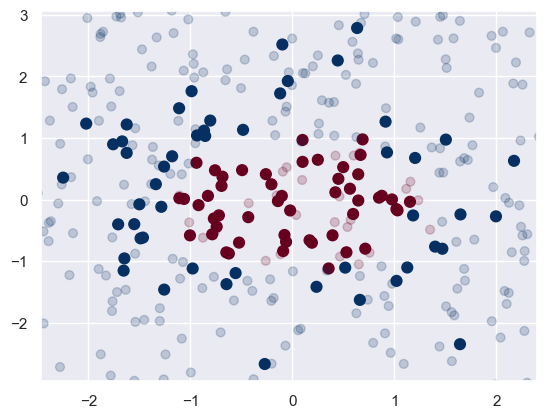

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=40, cmap='RdBu', alpha=0.2)
plt.axis(lim)

In [12]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.45, 0.55],
       [0.  , 1.  ]])

# In Depth: Naive Bayes Classification

## Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes.
In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*.
Imagine that you have the following data:

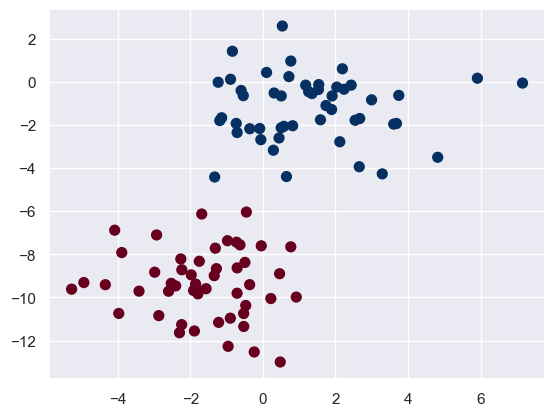

In [6]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions.
This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution.
The result of this naive Gaussian assumption is shown in the following figure:

![(run code in Appendix to generate image)](figures/05.05-gaussian-NB.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Gaussian-Naive-Bayes)

The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses.
With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's ``sklearn.naive_bayes.GaussianNB`` estimator:

In [7]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Now let's generate some new data and predict the label:

In [8]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is:

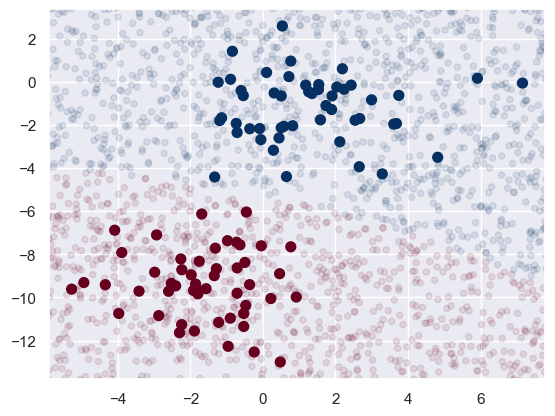

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

We see a slightly curved boundary in the classifications—in general, the boundary in Gaussian naive Bayes is quadratic.

A nice piece of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the ``predict_proba`` method:

In [10]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

The columns give the posterior probabilities of the first and second label, respectively.
If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a useful approach.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results.
Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label.
Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution.
The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.
We discussed the extraction of such features from text in [Feature Engineering](05.04-Feature-Engineering.ipynb); here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

##### Import Data 

In [13]:
import pandas as pd
newsDataRaw = pd.read_csv('bbc-news-data.csv', delimiter='\t')
newsDataRaw.head()


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


##### Data Preperation 

In [15]:
# Remove duplicates 
duplicated_rows = newsDataRaw[newsDataRaw.duplicated()]
print(f"Number of duplicated rows: {len(duplicated_rows)}")

Number of duplicated rows: 0


In [21]:
nulls  = newsDataRaw.isnull().sum()
print("Nulls in the dataset:\n", nulls_or_blanks)

Nulls in the dataset:
 category    0
filename    0
title       0
content     0
dtype: int64


## Modeling<a name="modeling"></a>

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [12]:
from sklearn.model_selection import train_test_split
categories = ['business' 'entertainment' 'politics' 'sport' 'tech']

train, test = train_test_split(
    newsDataRaw[['content', 'category']],
    test_size=0.2,
    random_state=42
)

# Print the sizes of the training and testing sets
print("Training set size:", len(train))
print("Testing set size:", len(test))

Training set size: 1780
Testing set size: 445


Here is a representative entry from the data:

In [13]:
print(train)

                                                content       category
1490   Ashley Cole has refused to blame Robin van Pe...          sport
2001   Sony PlayStation 2's slimmer shape has proved...           tech
1572   Newcastle have fined their Welsh striker Crai...          sport
1840   Re-using old mobile phones is not just good f...           tech
610    International films will be given the same pr...  entertainment
...                                                 ...            ...
1638   England captain Jason Robinson has rubbished ...          sport
1095   Middlesbrough mayor Ray Mallon has been draft...       politics
1130   The Lib Dems have appointed a senior figure f...       politics
1294   Sacked MP Howard Flight's local Conservative ...       politics
860    Women in the UK film industry earn less than ...  entertainment

[1780 rows x 2 columns]


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [15]:
model.fit(train['content'], train['category'])
labels = model.predict(test['content'])

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, here is the confusion matrix between the true and predicted labels for the test data:

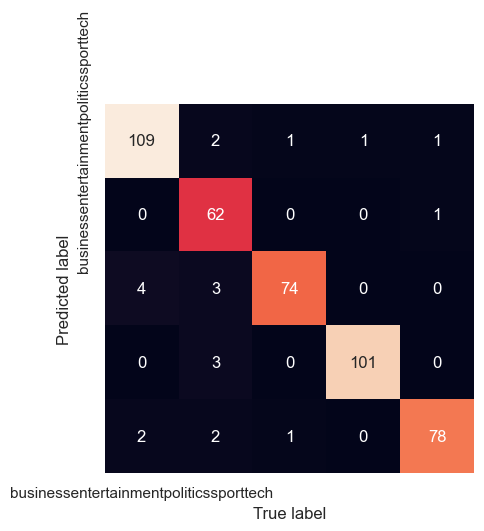

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test['category'], labels)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity.
This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for *any* string, using the ``predict()`` method of this pipeline.
Here's a quick utility function that will return the prediction for a single string:

In [17]:
def predict_category(input, model=model):
    pred = model.predict([input])
    return pred[0]


Let's try it out:

In [18]:
predict_category("when the market closed the stock then")

'business'

In [19]:
predict_category("has won her 1st Grammy")

'entertainment'

In [20]:
predict_category("In his second time running for election he ")

'politics'

In [21]:
predict_category("Have launched their new earphones")

'tech'

In [22]:
from sklearn.metrics import accuracy_score

true_labels = test['category']

accuracy = accuracy_score(true_labels, labels)

print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.95
